In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense,LSTM,Dropout,BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\ThinkPad\Downloads\LSTM-Multivariate_pollution.csv.zip")
df_test = pd.read_csv(r"C:\Users\ThinkPad\Downloads\pollution_test_data1.csv")
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [4]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [6]:
df_test.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dew        346 non-null    int64  
 1   temp       346 non-null    int64  
 2   press      346 non-null    int64  
 3   wnd_dir    346 non-null    object 
 4   wnd_spd    346 non-null    float64
 5   snow       346 non-null    int64  
 6   rain       346 non-null    int64  
 7   pollution  346 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 21.8+ KB


In [8]:
df_test.isna().sum()

dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64

In [9]:
df.shape,df_test.shape

((43800, 9), (346, 8))

In [10]:
#Data preprocessing and Visualization
df = df.drop(columns=['date'])
mapping = {'SE':0 , 'cv': 1, 'NW' :2, 'NE': 3}
df['wnd_dir'] = df['wnd_dir'].map(mapping)
df_test['wnd_dir'] = df_test['wnd_dir'].map(mapping)

array([[<Axes: title={'center': 'pollution'}>,
        <Axes: title={'center': 'dew'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'press'}>,
        <Axes: title={'center': 'wnd_dir'}>,
        <Axes: title={'center': 'wnd_spd'}>],
       [<Axes: title={'center': 'snow'}>,
        <Axes: title={'center': 'rain'}>, <Axes: >]], dtype=object)

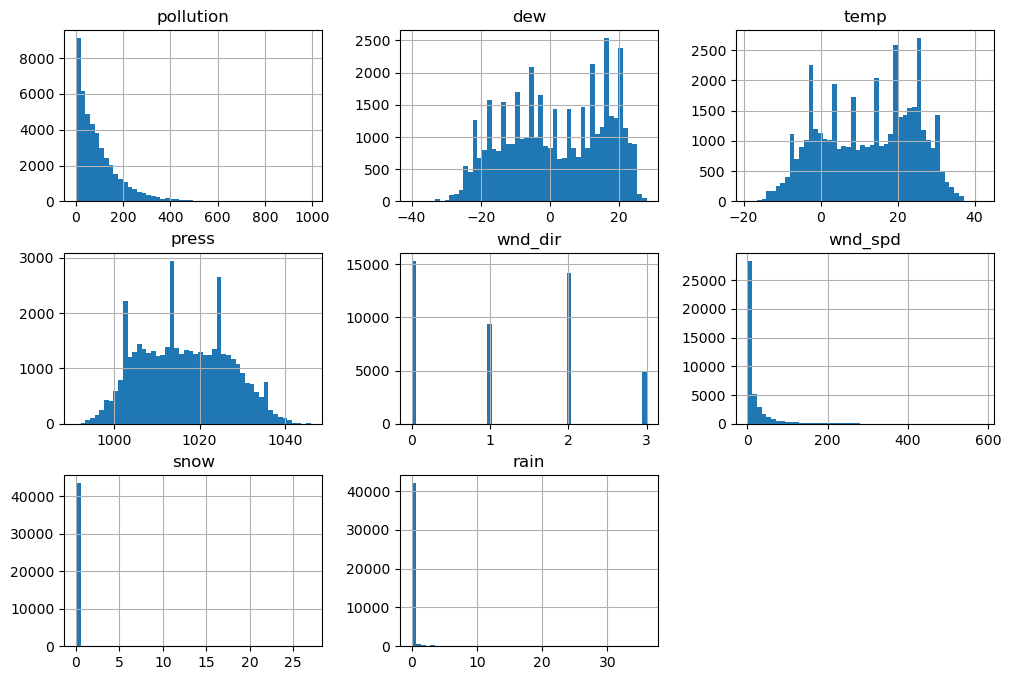

In [11]:
df.hist(figsize=(12,8),bins=50,)

<Axes: >

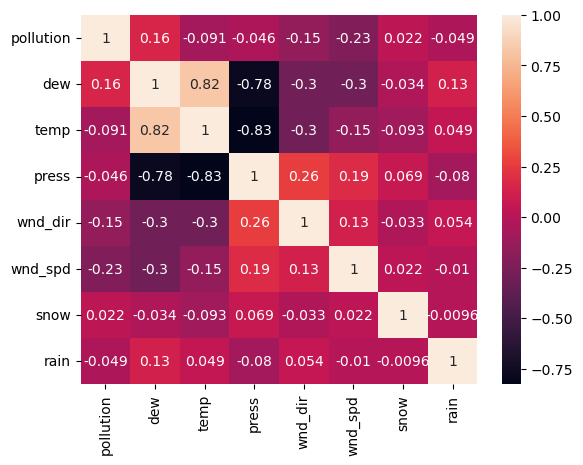

In [12]:
sns.heatmap(df.corr(),annot=True)

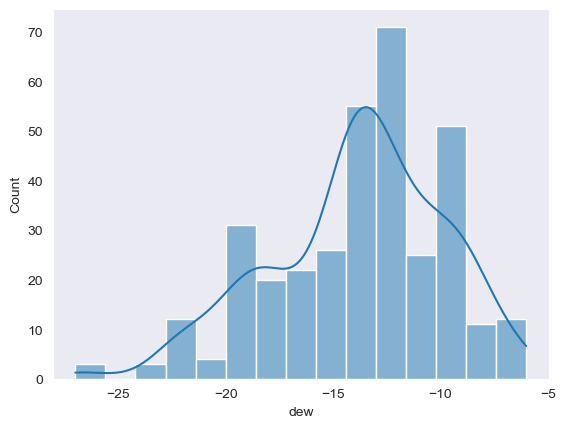

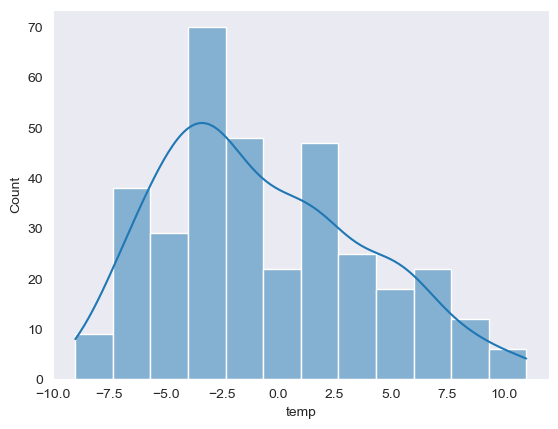

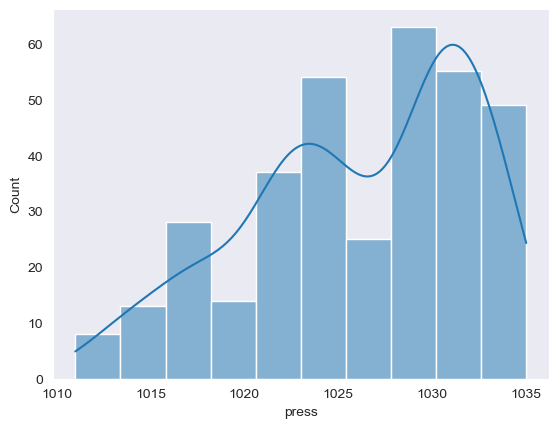

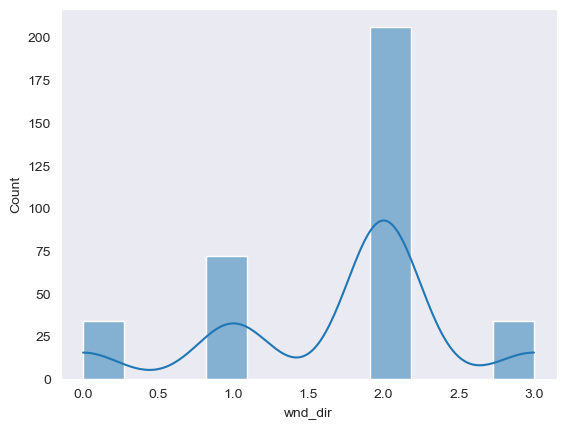

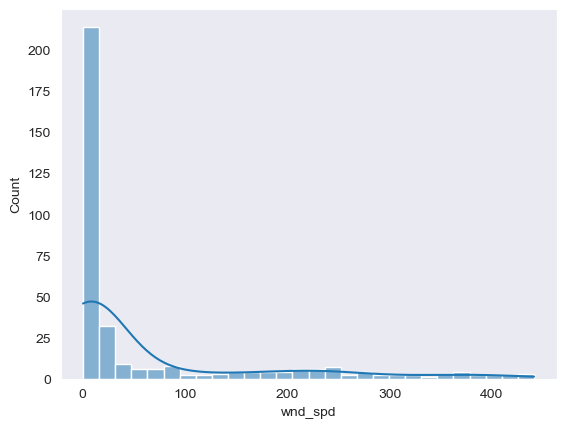

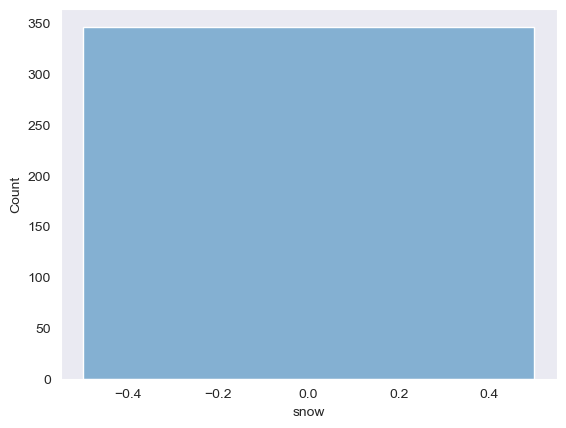

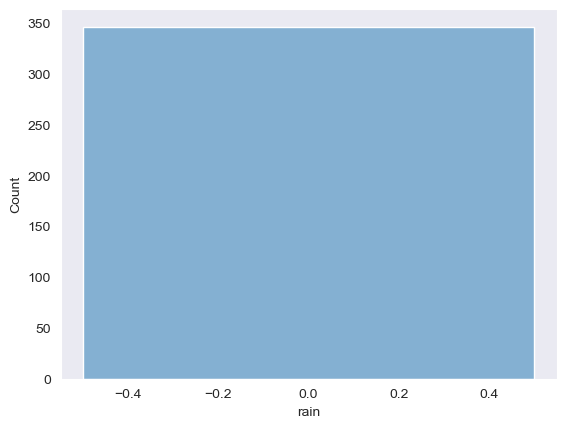

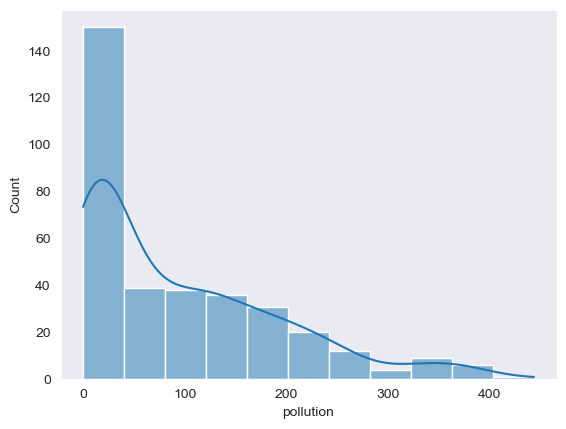

In [13]:
def plot(feature):
    sns.set_style('dark')
    sns.histplot(data = df_test,x = feature,kde=True)
    plt.show()

for feature in df_test.columns:
    plot(feature)

In [14]:
#Feature engineering
for col in ['temp', 'press', 'dew']:
    for lag in [1,2,3,6,12,24]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

for col in ['temp','press','wnd_spd']:
    df[f'{col}_rolling_mean_12'] = df[col].rolling(window=12).mean()
    df[f'{col}_rolling_std_12'] = df[col].rolling(window=12).std()
    df[f'{col}_rolling_mean_24'] = df[col].rolling(window=24).mean()

df['temp_pressure_interaction'] = df['temp'] * df['press']
df['temp_dew_diff'] = df['temp'] - df['dew']

for col in ['temp', 'press', 'dew']:
    for lag in [1,2,3,6,12,24]:
        df_test[f'{col}_lag_{lag}'] = df_test[col].shift(lag)
for col in ['temp','press','wnd_spd']:
    df_test[f'{col}_rolling_mean_12'] = df_test[col].rolling(window=12).mean()
    df_test[f'{col}_rolling_std_12'] = df_test[col].rolling(window=12).std()
    df_test[f'{col}_rolling_mean_24'] = df_test[col].rolling(window=24).mean()

df_test['temp_pressure_interaction'] = df_test['temp'] * df_test['press']
df_test['temp_dew_diff'] = df_test['temp'] - df_test['dew']

In [15]:
df = df.dropna()
df_test = df_test.dropna()

In [16]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,temp_lag_1,temp_lag_2,...,temp_rolling_std_12,temp_rolling_mean_24,press_rolling_mean_12,press_rolling_std_12,press_rolling_mean_24,wnd_spd_rolling_mean_12,wnd_spd_rolling_std_12,wnd_spd_rolling_mean_24,temp_pressure_interaction,temp_dew_diff
24,90.0,-7,-6.0,1027.0,0,58.56,4,0,-6.0,-6.0,...,0.452267,-5.208333,1026.666667,1.154701,1025.041667,43.355833,9.474337,27.225417,-6162.0,1.0
25,63.0,-8,-6.0,1026.0,0,61.69,5,0,-6.0,-6.0,...,0.492366,-5.291667,1026.750000,1.055290,1025.291667,46.187500,9.450941,29.684167,-6156.0,2.0
26,65.0,-8,-7.0,1026.0,0,65.71,6,0,-6.0,-6.0,...,0.674200,-5.375000,1026.833333,0.937437,1025.500000,49.019167,9.809142,32.273333,-7182.0,1.0
27,55.0,-8,-7.0,1025.0,0,68.84,7,0,-7.0,-6.0,...,0.778499,-5.458333,1026.833333,0.937437,1025.625000,51.776667,10.374623,34.918333,-7175.0,1.0
28,65.0,-8,-7.0,1024.0,0,72.86,8,0,-7.0,-7.0,...,0.834847,-5.541667,1026.666667,1.230915,1025.708333,54.720000,10.962028,37.693750,-7168.0,1.0


In [18]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

features = [col for col in df.columns if col != 'pollution' ]
target = 'pollution'

In [19]:
print(f"Number of features: {len(features)}")
print(f"Training data shape: {df.shape}")
print(f"Test data shape: {df_test.shape}")

Number of features: 36
Training data shape: (43776, 37)
Test data shape: (322, 37)


In [20]:
x_train_full = df[features].values
y_train_full = df[target].values
x_test_full = df_test[features].values
y_test_full = df_test[target].values

In [21]:
x_train_full.shape,y_test_full.shape

((43776, 36), (322,))

In [22]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaled = X_scaler.fit_transform(x_train_full)
x_test_scaled = X_scaler.transform(x_test_full)

y_train_scaled = y_scaler.fit_transform(y_train_full.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test_full.reshape(-1, 1)).ravel()

In [23]:
def sequence(x,y,timestep):
    xs,ys = [],[]
    for i in range(timestep,len(x)):
        xs.append(x[i-timestep:i])
        ys.append(y[i])
    return np.array(xs),np.array(ys)

In [24]:
TIMESTEP = 24
x_seq, y_seq = sequence(x_scaled, y_train_scaled, TIMESTEP)
x_test_seq, y_test_seq = sequence(x_test_scaled, y_test_scaled, TIMESTEP)

X_train, X_val, y_train, y_val = train_test_split(
    x_seq, y_seq, test_size=0.2, shuffle=False, random_state=42)

In [25]:
X_train,X_val,y_train,y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=42,shuffle=False)

In [26]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
model = Sequential([
   LSTM(units=128,activation='tanh',
        return_sequences=True,
        input_shape = (X_train.shape[1],X_train.shape[2]),
        kernel_regularizer=l2(0.0001),
        dropout = 0.2,
        recurrent_dropout=0.1
        ),
    BatchNormalization(),

   LSTM(units=64,
        activation='tanh',
        return_sequences=False,
        kernel_regularizer = l2(0.0001),
        dropout=0.2,
        recurrent_dropout=0.1
        ),
    BatchNormalization(),
    Dense(units = 32,activation='relu',kernel_regularizer=l2(0.0001)),
    Dropout(rate=0.2),
    Dense(units=16,activation='relu'),
    Dropout(rate=0.1),
    Dense(units=1)
])

c:\Users\ThinkPad\anaconda3\envs\mlenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,281 (536.25 KB)

 Trainable params: 136,897 (534.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [28]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate = 0.001),loss = 'huber',metrics=['mae'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
early_stop = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_loss')
lr_scedule = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 5,min_lr = 1e-6)
checkpoint = ModelCheckpoint('best_model_lastm.h5',save_best_only=True,monitor='val_loss')

In [30]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=32,verbose=1,callbacks=[early_stop,lr_scedule,checkpoint])

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0566 - mae: 0.1581

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - loss: 0.0352 - mae: 0.0987 - val_loss: 0.0221 - val_mae: 0.0646 - learning_rate: 0.0010
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0193 - mae: 0.0666

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 90s 53ms/step - loss: 0.0168 - mae: 0.0657 - val_loss: 0.0121 - val_mae: 0.0598 - learning_rate: 0.0010
Epoch 3/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0108 - mae: 0.0620

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - loss: 0.0096 - mae: 0.0614 - val_loss: 0.0079 - val_mae: 0.0623 - learning_rate: 0.0010
Epoch 4/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0068 - mae: 0.0597

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 0.0061 - mae: 0.0588 - val_loss: 0.0051 - val_mae: 0.0556 - learning_rate: 0.0010
Epoch 5/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0046 - mae: 0.0566

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 0.0044 - mae: 0.0571 - val_loss: 0.0036 - val_mae: 0.0504 - learning_rate: 0.0010
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038 - mae: 0.0562

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.0037 - mae: 0.0560 - val_loss: 0.0034 - val_mae: 0.0589 - learning_rate: 0.0010
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0035 - mae: 0.0558 - val_loss: 0.0048 - val_mae: 0.0600 - learning_rate: 0.0010
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0035 - mae: 0.0557

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.0034 - mae: 0.0551 - val_loss: 0.0033 - val_mae: 0.0552 - learning_rate: 0.0010
Epoch 9/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - loss: 0.0034 - mae: 0.0550 - val_loss: 0.0051 - val_mae: 0.0587 - learning_rate: 0.0010
Epoch 10/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 65s 33ms/step - loss: 0.0033 - mae: 0.0545 - val_loss: 0.0035 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 11/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0033 - mae: 0.0536

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.0033 - mae: 0.0535 - val_loss: 0.0030 - val_mae: 0.0537 - learning_rate: 0.0010
Epoch 12/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.0033 - mae: 0.0537 - val_loss: 0.0040 - val_mae: 0.0576 - learning_rate: 0.0010
Epoch 13/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0032 - mae: 0.0534

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - loss: 0.0032 - mae: 0.0529 - val_loss: 0.0030 - val_mae: 0.0499 - learning_rate: 0.0010
Epoch 14/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - loss: 0.0032 - mae: 0.0529 - val_loss: 0.0033 - val_mae: 0.0521 - learning_rate: 0.0010
Epoch 15/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 0.0031 - mae: 0.0526 - val_loss: 0.0032 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 16/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 0.0031 - mae: 0.0521 - val_loss: 0.0039 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 17/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.0029 - mae: 0.0510 - val_loss: 0.0031 - val_mae: 0.0475 - learning_rate: 5.0000e-04
Epoch 18/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0029 - mae: 0.0502

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 0.0029 - mae: 0.0504 - val_loss: 0.0029 - val_mae: 0.0470 - learning_rate: 5.0000e-04
Epoch 19/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028 - mae: 0.0503

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 0.0029 - mae: 0.0507 - val_loss: 0.0029 - val_mae: 0.0471 - learning_rate: 5.0000e-04
Epoch 20/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0029 - mae: 0.0503

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.0029 - mae: 0.0506 - val_loss: 0.0026 - val_mae: 0.0496 - learning_rate: 5.0000e-04
Epoch 21/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 0.0029 - mae: 0.0506 - val_loss: 0.0028 - val_mae: 0.0542 - learning_rate: 5.0000e-04
Epoch 22/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.0029 - mae: 0.0505 - val_loss: 0.0026 - val_mae: 0.0451 - learning_rate: 5.0000e-04
Epoch 23/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.0029 - mae: 0.0503 - val_loss: 0.0031 - val_mae: 0.0469 - learning_rate: 5.0000e-04
Epoch 24/50
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0029 - mae: 0.0502

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - loss: 0.0028 - mae: 0.0501 - val_loss: 0.0025 - val_mae: 0.0487 - learning_rate: 5.0000e-04
Epoch 25/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.0028 - mae: 0.0499 - val_loss: 0.0027 - val_mae: 0.0473 - learning_rate: 5.0000e-04
Epoch 26/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0027 - mae: 0.0489

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 0.0027 - mae: 0.0492 - val_loss: 0.0025 - val_mae: 0.0486 - learning_rate: 2.5000e-04
Epoch 27/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0027 - mae: 0.0492

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0027 - mae: 0.0492 - val_loss: 0.0024 - val_mae: 0.0462 - learning_rate: 2.5000e-04
Epoch 28/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0027 - mae: 0.0491 - val_loss: 0.0026 - val_mae: 0.0524 - learning_rate: 2.5000e-04
Epoch 29/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - loss: 0.0027 - mae: 0.0488 - val_loss: 0.0025 - val_mae: 0.0484 - learning_rate: 2.5000e-04
Epoch 30/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.0027 - mae: 0.0489 - val_loss: 0.0025 - val_mae: 0.0450 - learning_rate: 2.5000e-04
Epoch 31/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0027 - mae: 0.0490

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 0.0027 - mae: 0.0489 - val_loss: 0.0023 - val_mae: 0.0459 - learning_rate: 2.5000e-04
Epoch 32/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - loss: 0.0027 - mae: 0.0487 - val_loss: 0.0025 - val_mae: 0.0471 - learning_rate: 2.5000e-04
Epoch 33/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.0027 - mae: 0.0487 - val_loss: 0.0025 - val_mae: 0.0465 - learning_rate: 2.5000e-04
Epoch 34/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.0027 - mae: 0.0488 - val_loss: 0.0025 - val_mae: 0.0504 - learning_rate: 2.5000e-04
Epoch 35/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - loss: 0.0027 - mae: 0.0486 - val_loss: 0.0025 - val_mae: 0.0457 - learning_rate: 2.5000e-04
Epoch 36/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.0027 - mae: 0.0487 - val_loss: 0.0025 - val_mae: 0.0488 - learning_rate: 2.5000e-04


In [31]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
train_pred_scaled = model.predict(X_train, verbose=0)
val_pred_scaled = model.predict(X_val, verbose=0)
test_pred_scaled = model.predict(x_test_seq, verbose=0)
train_pred = y_scaler.inverse_transform(train_pred_scaled).ravel()
val_pred = y_scaler.inverse_transform(val_pred_scaled).ravel()
test_pred = y_scaler.inverse_transform(test_pred_scaled).ravel()

train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
val_true = y_scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()
test_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

In [34]:
from sklearn.metrics import mean_absolute_percentage_error
def evaluation(y_true,y_pred,dataset_name = 'Test'):
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true,y_pred)

    print(f"\n{dataset_name} Set Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    
    
 
    
    fig,axes = plt.subplots(2,2,figsize = (15,10))
    
    axes[0, 0].scatter(y_true, y_pred, alpha=0.6, s=20)
    axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title(f'{dataset_name}: Predicted vs Actual')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals plot
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title(f'{dataset_name}: Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Time series plot (first 200 points)
    n_points = min(200, len(y_true))
    axes[1, 0].plot(y_true[:n_points], label='Actual', alpha=0.8)
    axes[1, 0].plot(y_pred[:n_points], label='Predicted', alpha=0.8)
    axes[1, 0].set_xlabel('Time Steps')
    axes[1, 0].set_ylabel('Pollution Level')
    axes[1, 0].set_title(f'{dataset_name}: Time Series Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Error distribution
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'{dataset_name}: Error Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Train Set Metrics:
MAE: 46.3259
MSE: 4369.9673
RMSE: 66.1057
R² Score: 0.4831


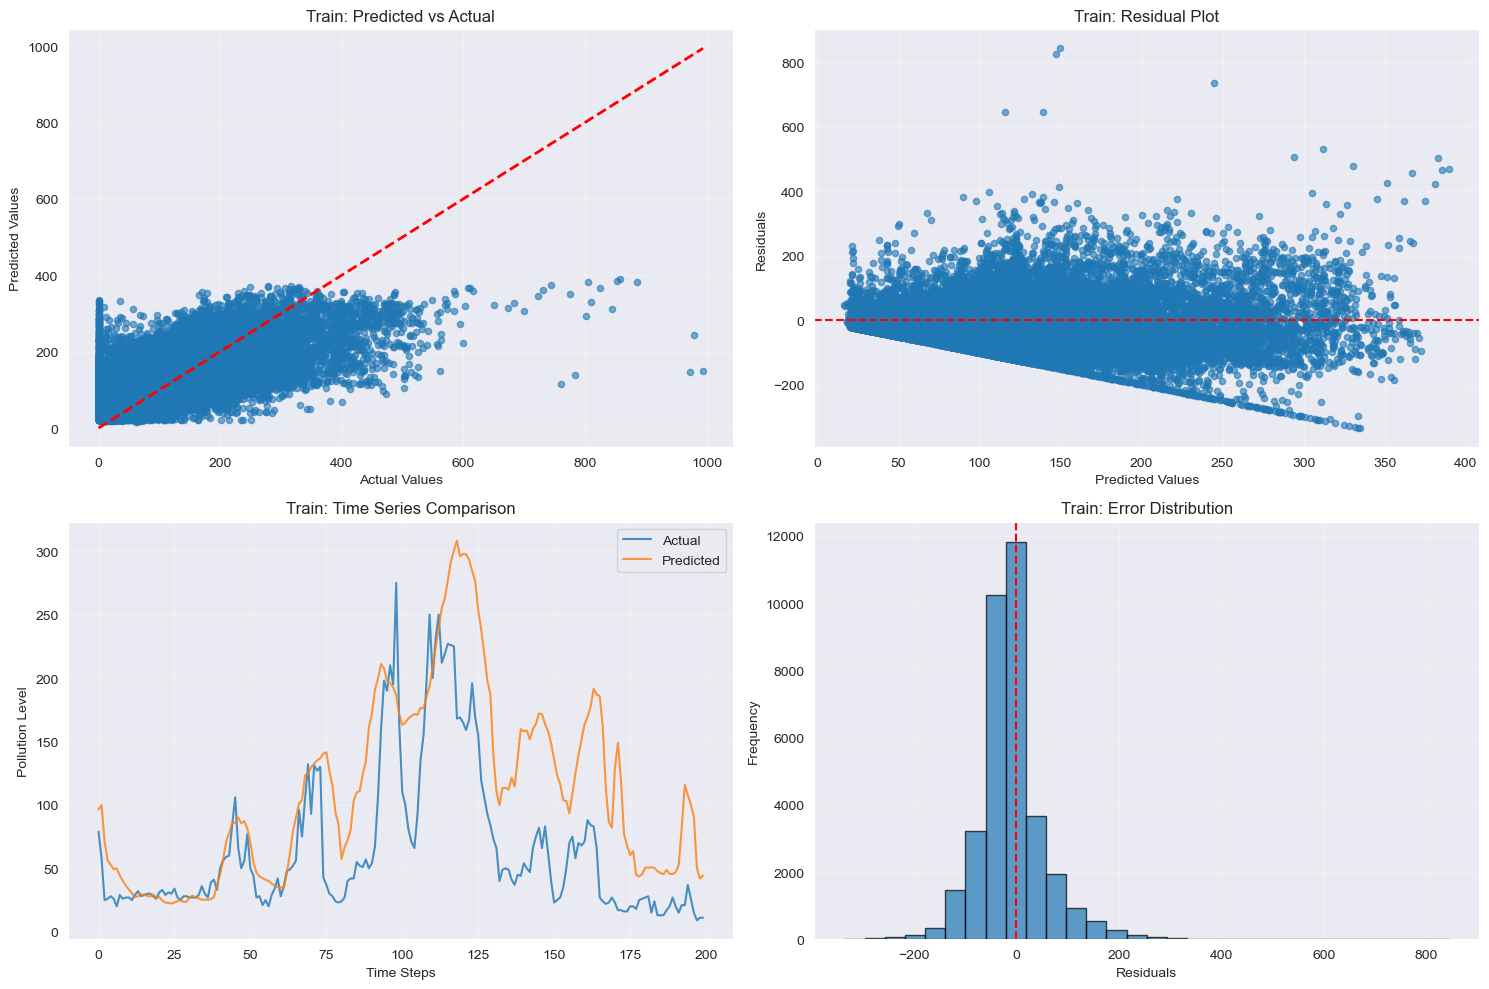


Validation Set Metrics:
MAE: 45.6295
MSE: 4211.3980
RMSE: 64.8953
R² Score: 0.5194


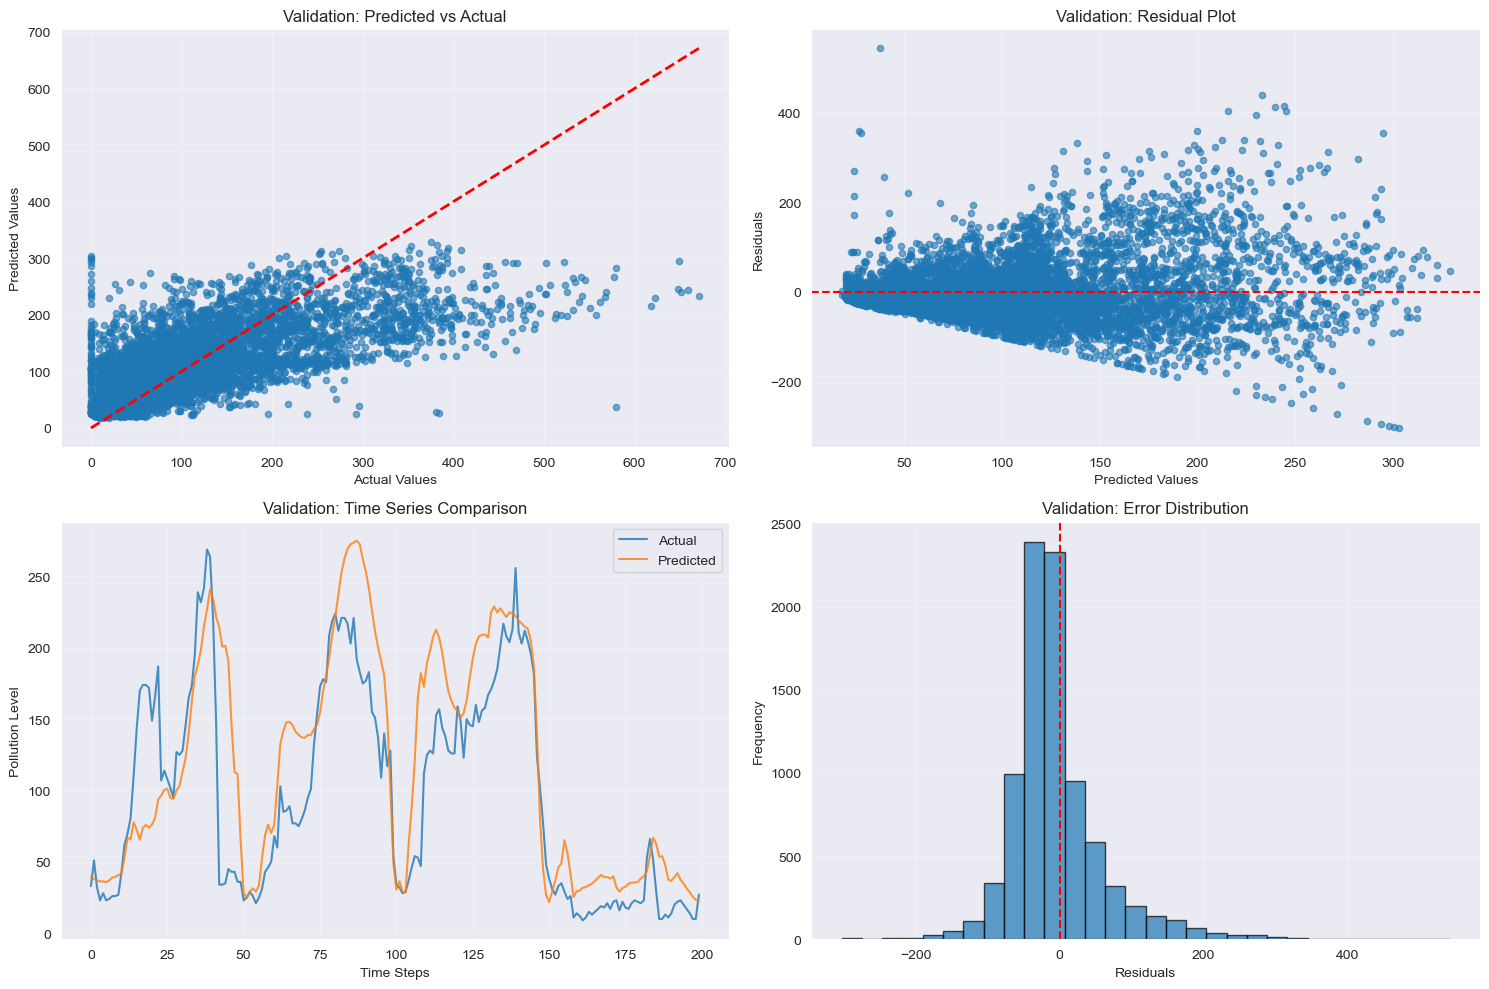


Test Set Metrics:
MAE: 41.7099
MSE: 3301.3106
RMSE: 57.4570
R² Score: 0.6626


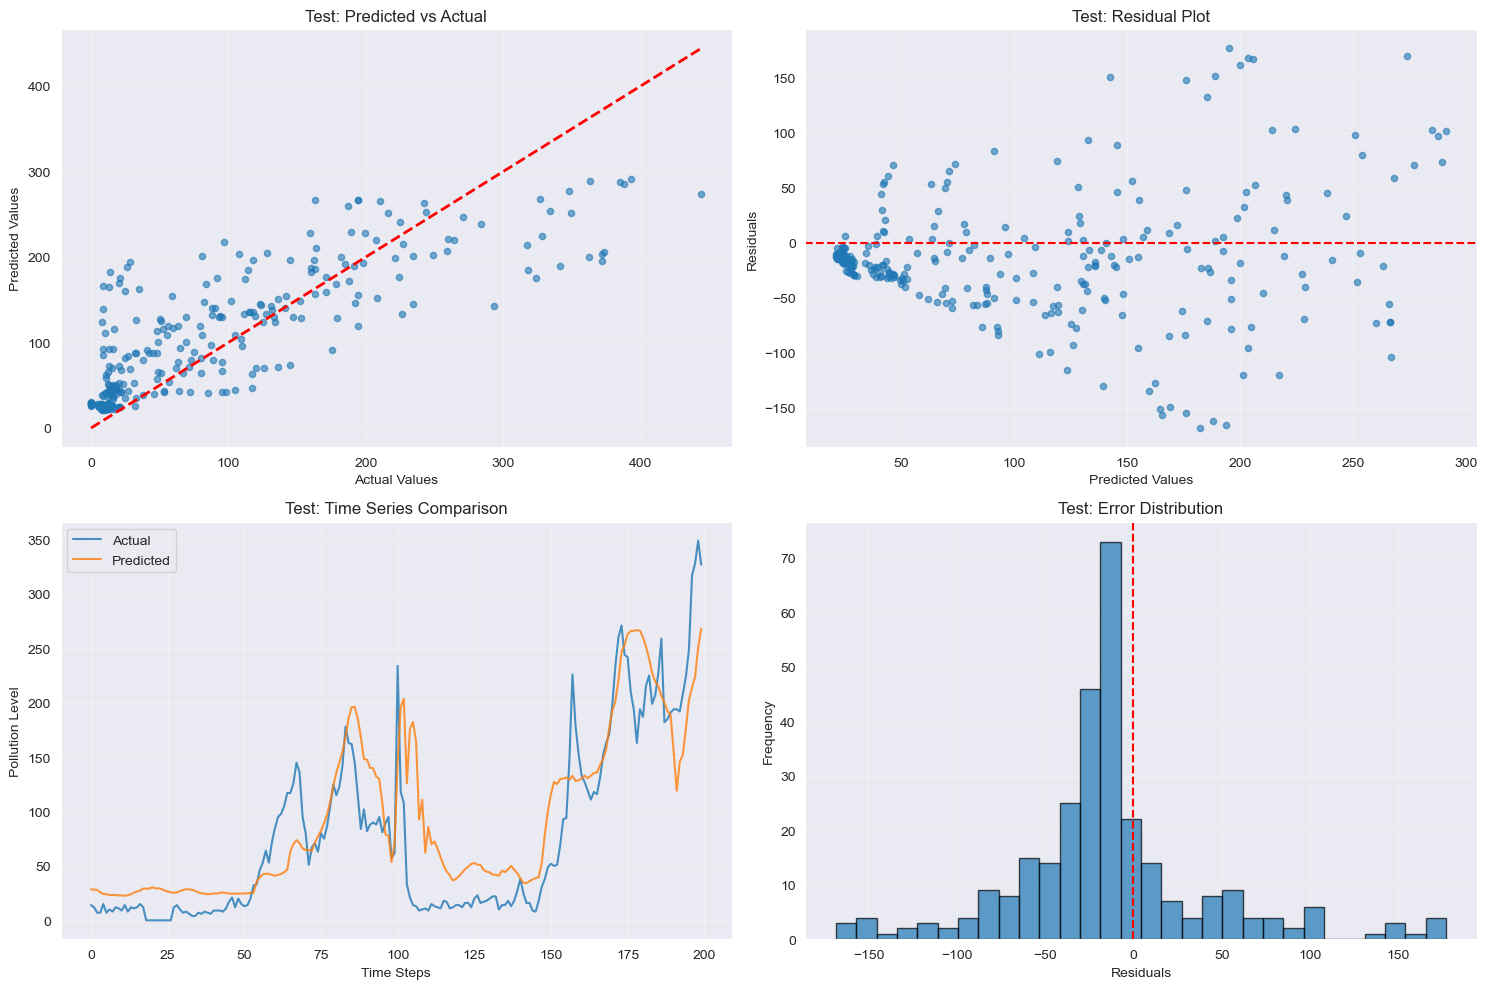

In [35]:
evaluation(train_true,train_pred,dataset_name='Train')
evaluation(val_true,val_pred,dataset_name='Validation')
evaluation(test_true,test_pred,dataset_name='Test')